# Load data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import polars as pl
import tqdm
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import chi2_contingency, ttest_ind, pearsonr

In [ ]:
path = '/gdrive/MyDrive/Nhóm 1/2 Bài tập trên lớp/Thực hành Final/Data processed/final_dataset.csv'
df = pd.read_csv(path)
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_584313,"introduction to ""zi zhi tong jian""",3,NaN,NaN,NaN,NaN,NaN,91,1.0,NaN
1,C_584329,calculus - limit theory and functions of one v...,6,NaN,NaN,NaN,NaN,NaN,170,1.0,NaN
2,C_584329,calculus - limit theory and functions of one v...,6,NaN,NaN,NaN,NaN,NaN,170,1.0,NaN
3,C_584381,photojournalism,5,NaN,NaN,NaN,NaN,NaN,127,1.0,NaN
4,C_597208,data mining: theory and algorithms,10,NaN,NaN,NaN,NaN,NaN,125,1.0,NaN


# Data Quality

##1. Độ chính xác (Accuracy)

### 1.1 Phân tích thống kê

####1.1.1 Tỷ lệ lỗi

In [ ]:
df.shape

(14194, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14194 entries, 0 to 14193
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       14194 non-null  object 
 1   name                     14194 non-null  object 
 2   num_users                14194 non-null  int64  
 3   total_cmt                10392 non-null  float64
 4   positive                 10392 non-null  float64
 5   negative                 10392 non-null  float64
 6   neutral                  10392 non-null  float64
 7   average_completion_rate  3380 non-null   float64
 8   number of resources      14194 non-null  int64  
 9   rank_binned              11981 non-null  float64
 10  course_classification    2861 non-null   object 
dtypes: float64(6), int64(2), object(3)
memory usage: 1.2+ MB


Nhận xét:
* Các cột như id và name là dữ liệu được thu thập từ hệ thống nên sẽ không có dữ liệu bị sai.
* Xét các cột còn lại, các cột dạng số sẽ xét xem có giá trị âm không (nếu âm là dữ liệu bị sai), cột `course_classification` sẽ kiểm tra giá trị có nằm trong các nhãn `bad`, `normal`, `good`.
* Ngoài ra sẽ kiểm tra tổng comment có bằng tổng positive + negative + neutral hay không

Kiểm tra giá trị các cột `total_cmt`, `positive`, `neutral`, `negative`, `num_users`, `num_of_resources` có âm hay không.

In [ ]:
error_data = ((df['total_cmt'] < 0) |
              (df['positive'] < 0) |
              (df['neutral'] < 0) |
              (df['negative'] < 0) |
              (df['num_users'] < 0) |
              (df['number of resources'] < 0)).sum()

error_data

0

Kiểm tra giá trị của cột `average_completion_rate` có nằm trong đoạn [0, 1] hay không

In [ ]:
error_data = error_data + ((df['average_completion_rate'] < 0) |
              (df['average_completion_rate'] > 1)).sum()

error_data

0

* Kiểm tra giá trị của cột `course_classification` chỉ chứa các nhãn `Very dissatisfied`, `Dissatisfied`, `Neutral`, `Satisfied`, `Very satisfied` không
* Kiểm tra tổng comment có bằng tổng positive + negative + neutral không


In [ ]:
error_data = error_data + (((df['course_classification'].isin(['Very dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very satisfied']) == False) |
                            (df['total_cmt'] != (df['positive'] + df['neutral'] + df['negative']))).sum())

error_data

11333

In [ ]:
error_rate = (error_data / df.shape[0])*100
print('Tỷ lệ lỗi trong data là: ', round(error_rate, 2), '%')

Tỷ lệ lỗi trong data là:  79.84 %


Nhận xét:
* Số data bị lỗi là 11333.
* Tỷ lệ lỗi trong data là 79.84%

####1.1.2 Độ lệch chuẩn

In [ ]:
df.describe()

,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned
count,14194.000000,10392.000000,10392.000000,10392.000000,10392.000000,3380.000000,14194.000000,11981.000000
mean,5797.713752,341.408102,99.865955,23.037144,218.505004,0.648872,85.422784,4.481596
std,10643.185636,1032.341823,360.152818,69.355876,708.305655,0.215108,71.118987,3.201565
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,291.000000,8.000000,2.000000,1.000000,4.000000,0.545455,48.000000,1.000000
50%,2519.000000,40.000000,7.000000,3.000000,22.000000,0.681895,69.000000,4.000000
75%,6844.000000,197.000000,44.000000,14.000000,133.000000,0.788779,102.000000,7.000000
max,231674.000000,33130.000000,10585.000000,1498.000000,25722.000000,1.000000,2728.000000,11.000000


Nhận xét:
*  Chỉ có cột `average_completion_rate` có giá trị std khá thấp 0.648872, điều này cho thấy mức độ biến động của dữ liệu cột này khá thấp.
* Các cột còn lại giá trị std khá cao đặc biệt là cột `num_users` với giá trị std là 5797.713752, điều này cho thấy mức độ biến động của dữ liệu khá cao.


####1.1.3 Hệ số tương quan

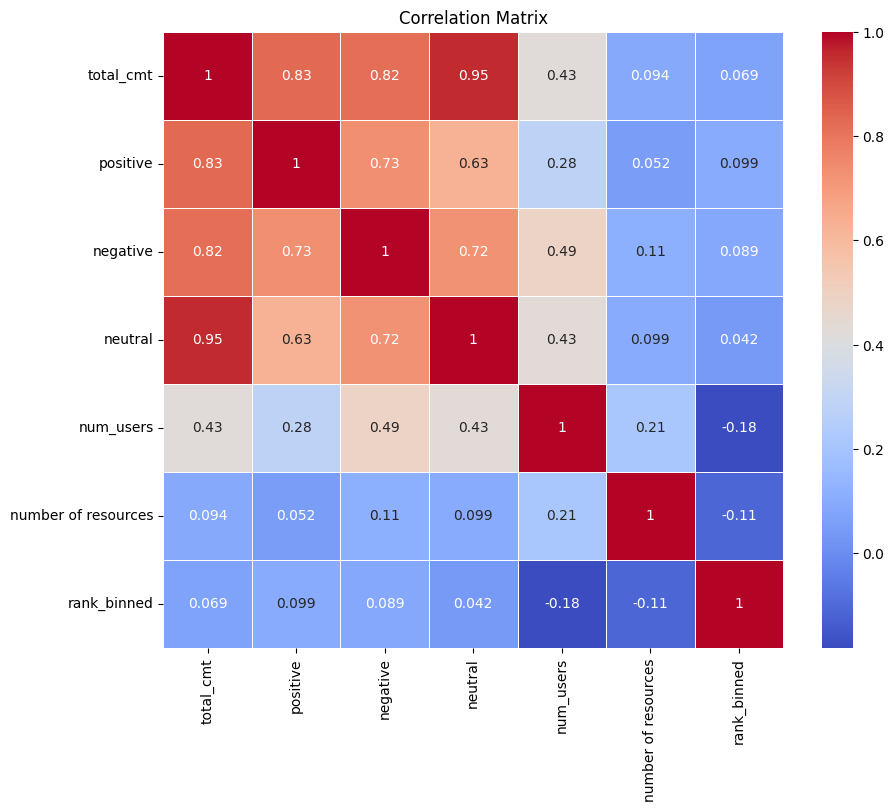

In [ ]:
selected_columns = ['total_cmt', 'positive', 'negative', 'neutral', 'num_users', 'number of resources', 'rank_binned']
correlation_matrix = df[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Nhận xét:
* total_cmt và neutral (0.95): Có mối tương quan dương rất mạnh. Điều này có nghĩa là khi số lượng total_cmt tăng, số lượng neutral cũng tăng đáng kể và ngược lại.
* total_cmt và positive (0.83): Có mối tương quan dương mạnh. Khi số lượng total_cmt tăng, số lượng positive cũng có xu hướng tăng.
* neutral và positive (0.63): Có mối tương quan dương ở mức trung bình. Điều này chỉ ra rằng khi số lượng neutral tăng, số lượng positive cũng có xu hướng tăng nhưng không mạnh bằng so với mối tương quan với total_cmt.
* negative và total_cmt (0.82): Có mối tương quan dương mạnh. Điều này có nghĩa là khi số lượng total_cmt tăng, số lượng negative cũng tăng đáng kể.
* negative và neutral (0.72): Có mối tương quan dương khá mạnh. Khi số lượng neutral tăng, số lượng negative cũng có xu hướng tăng, cho thấy hai loại bình luận này có thể xuất hiện cùng nhau.
* negative và positive (0.73): Có mối tương quan dương khá mạnh. Điều này cho thấy khi số lượng positive tăng, số lượng negative cũng tăng, nhưng mối liên hệ này không quá mạnh.
* negative và num_users (0.49): Có mối tương quan dương nhẹ. Khi số lượng num_users tăng, số lượng negative cũng tăng một chút, nhưng không rõ ràng.
* total_cmt và num_users (0.43): Có mối tương quan dương nhẹ, chỉ ra rằng khi số lượng total_cmt tăng, num_users cũng tăng một chút nhưng không rõ ràng.
* Các cặp còn lại (các hệ số rất gần 0): Các biến này không có mối tương quan rõ ràng với nhau, ví dụ như giữa number of resources với các biến khác. Những mối quan hệ này cho thấy khi một biến thay đổi, các biến kia hầu như không thay đổi.


##2. Tính đầy đủ (Completeness)

###2.1 Phân tích thống kê

####2.1.1 Tỷ lệ dữ liệu thiếu

In [ ]:
# Tìm các giá trị null
null_values = df.isnull().sum()

# Tính tổng số giá trị
true_values = df.count().sort_values(ascending=True)

# Tính phần trăm giá trị null
wrong_value_percentage = null_values / len(df) * 100

# Chuyển đổi thành dataframe của các giá trị thiếu
missing_values_df = pd.concat({'True values': true_values, 'Null values': null_values, 'Missing percentage': wrong_value_percentage}, axis=1)

# Hiển thị các giá trị thiếu
missing_values_df

,True values,Null values,Missing percentage
course_classification,2861,11333,79.843596
average_completion_rate,3380,10814,76.187121
total_cmt,10392,3802,26.785966
positive,10392,3802,26.785966
negative,10392,3802,26.785966
neutral,10392,3802,26.785966
rank_binned,11981,2213,15.591095
id,14194,0,0.000000
name,14194,0,0.000000
num_users,14194,0,0.000000


Nhận xét: file final_dataset có dữ liệu thiếu ở các cột `average_completion_rate` (76.18% tỷ lệ thiếu), `course_classification` (79.84% tỷ lệ thiếu), `total_cmt`, `positive`, `negative`, neutral` ( 26.78% tỷ lệ thiếu), `rank_binned` (15.59% tỷ lệ thiếu).

In [ ]:
missing_rate = df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100
print('Tỷ lệ dữ liệu bị thiếu trong data là: ', round(missing_rate, 2), '%')

Tỷ lệ dữ liệu bị thiếu trong data là:  25.34 %


####2.2.2 Phân tích phân bố

Để trực quan hóa dữ liệu bị thiếu dùng thư viện Missingno

Sử dụng hàm bar() để hiển thị các giá trị bị thiếu trên mỗi cột

<Axes: >

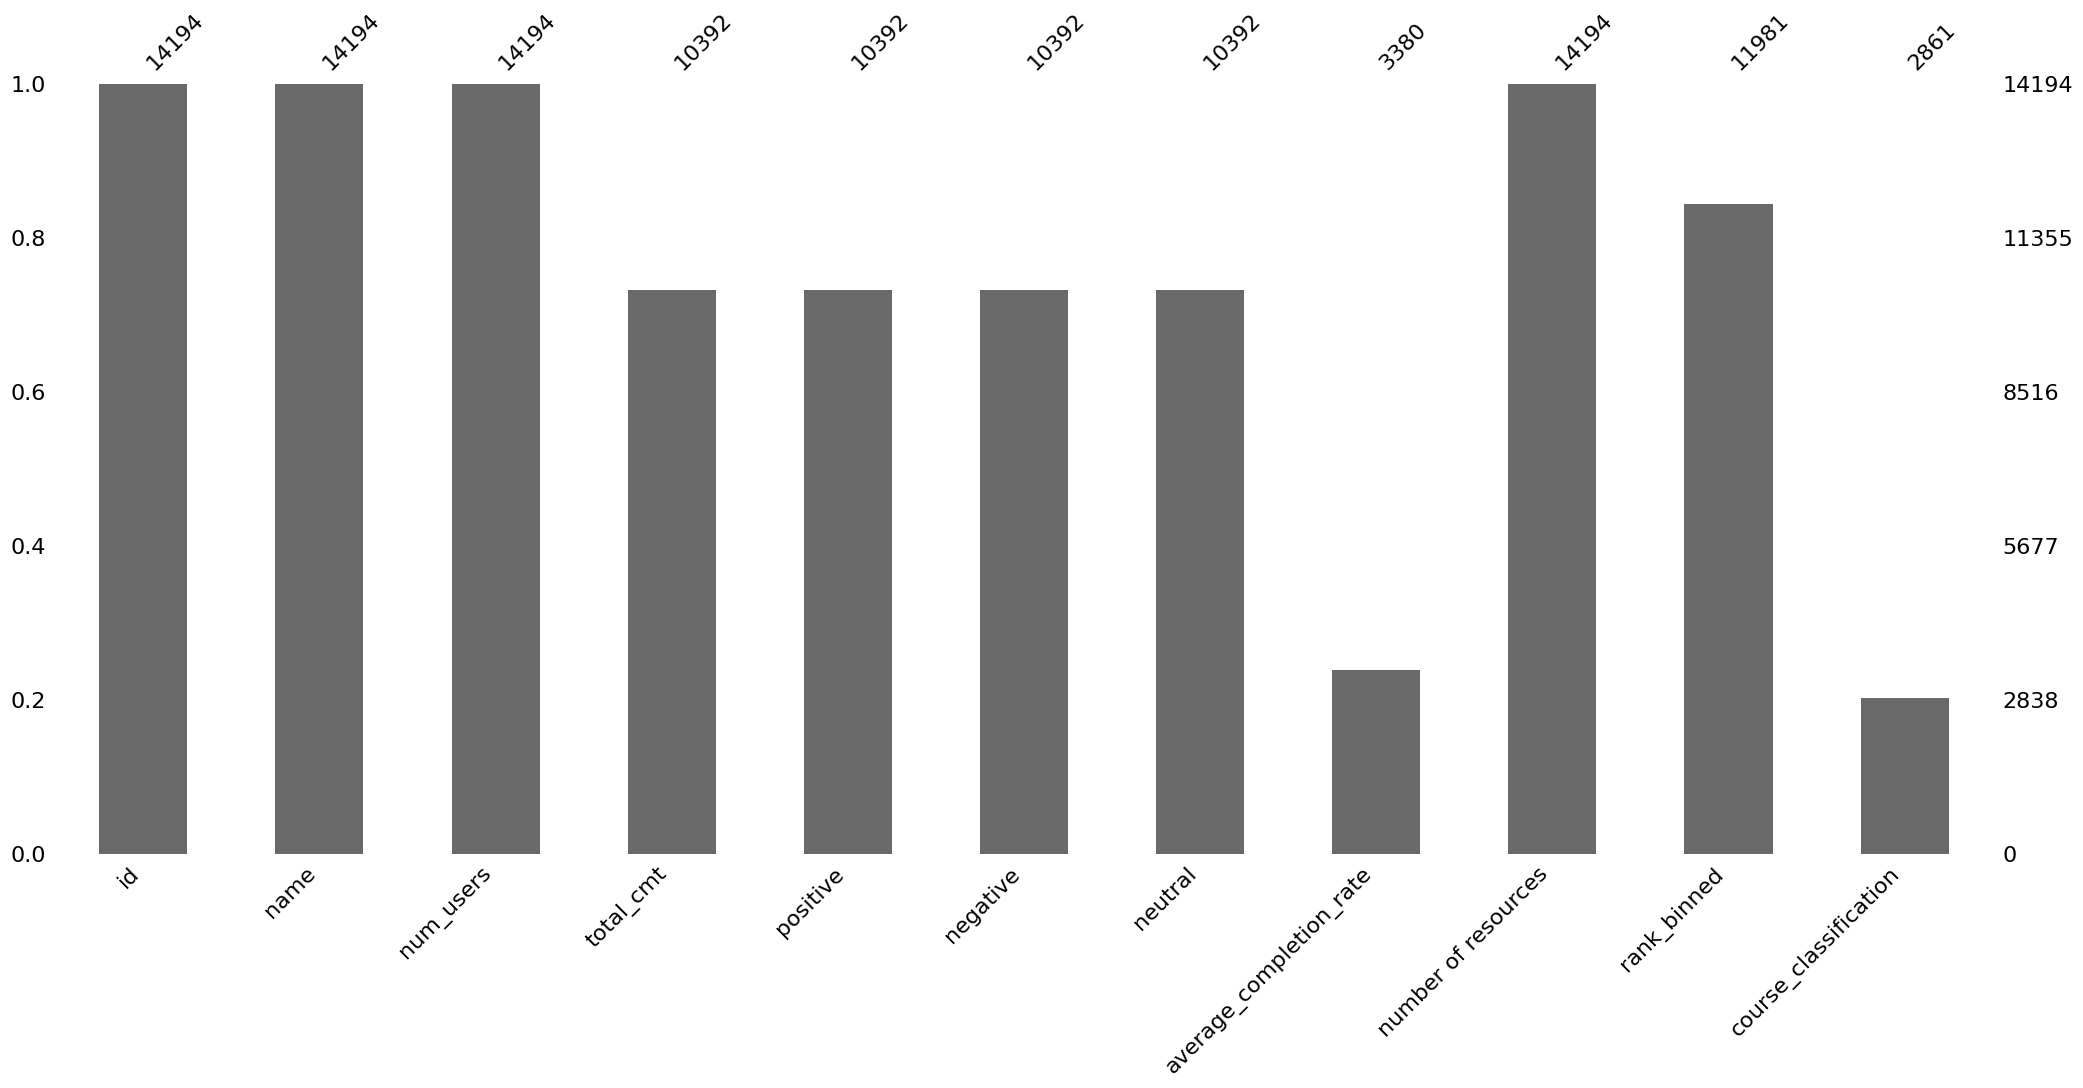

In [ ]:
import missingno as msno
msno.bar(df)

Sử dụng hàm matrix() để vẽ biểu đồ ma trận cho thấy vị trí và số lượng các giá trị bị thiếu trong DataFrame

<Axes: >

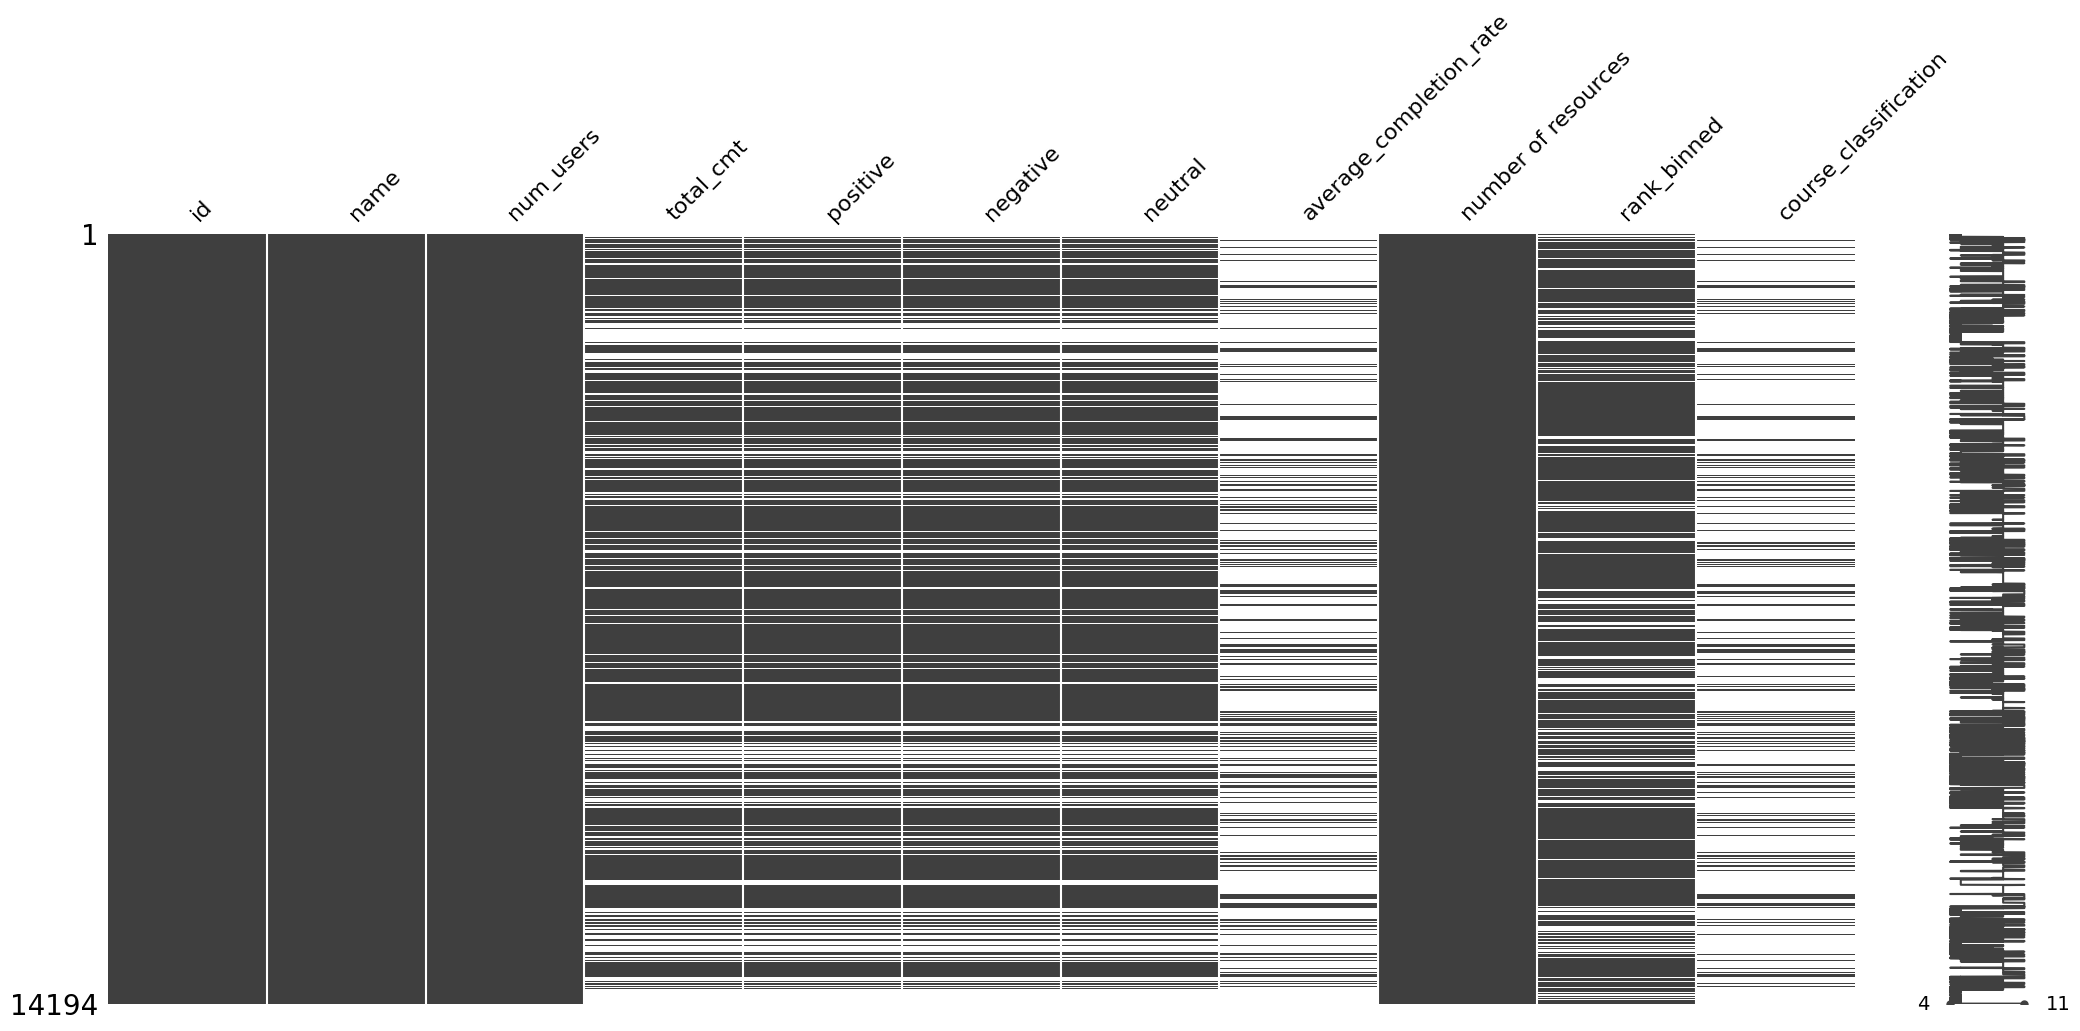

In [ ]:
msno.matrix(df)

Nhận xét:
* Các khoảng trắng trong biểu đồ chính là những chỗ vị trí dữ liệu bị thiếu ở mỗi cột.
* Cột `average_completion_rate` và `course_classification` bị thiếu khá nhiều (khoảng 70%).
* Cột `total_cmt`, `positive`, `negative`, `neutral` bị thiếu khoảng 50%.
* Các cột còn lại đầy đủ.

Sử dụng hàm heatmap() để thể hiện mối quan hệ giữa các cột có dữ liệu bị thiếu

<Axes: >

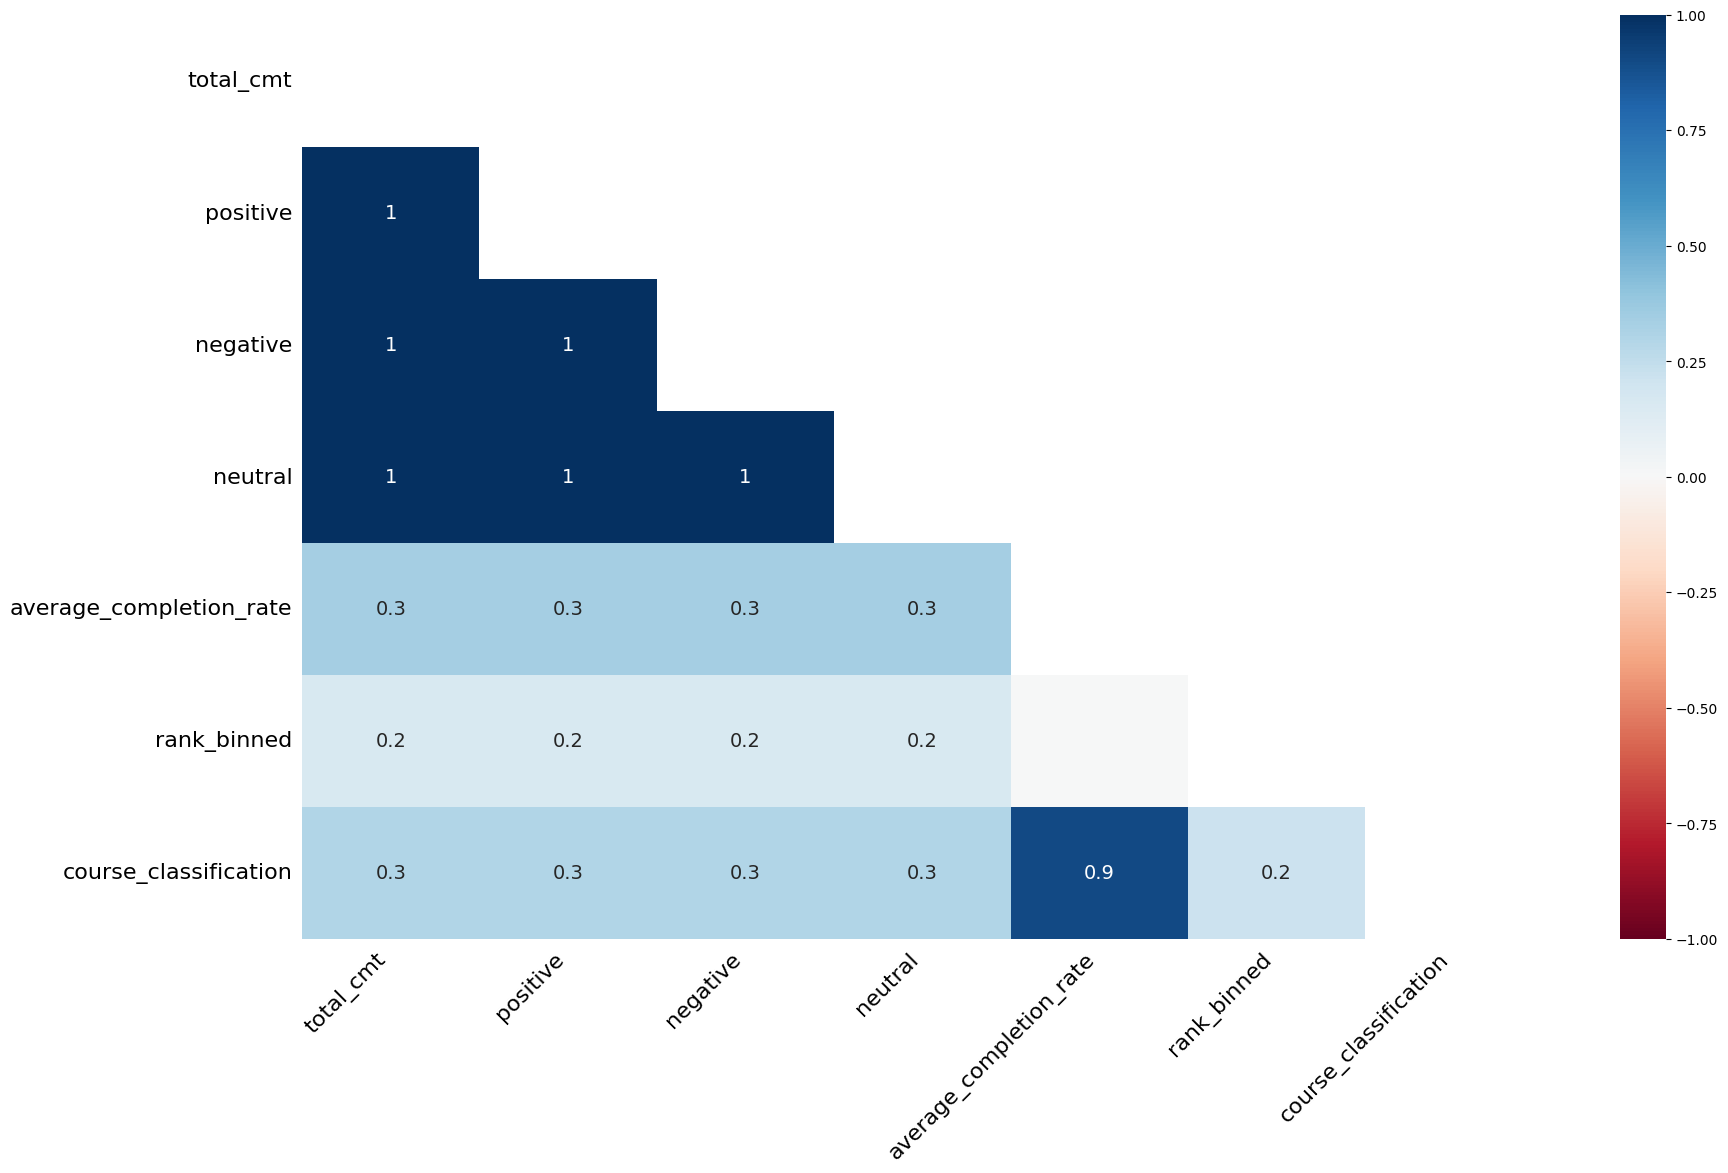

In [ ]:
msno.heatmap(df)

Nhận xét:
* total_cmt, positive, negative, neutral: Các biến này có mối tương quan hoàn hảo (1) với nhau. Điều này cho thấy rằng các loại bình luận khác nhau (positive, negative, neutral) đều tăng hoặc giảm cùng với total_cmt, và chúng có xu hướng tỷ lệ thuận với nhau.
* average_completion_rate và các biến bình luận (total_cmt, positive, negative, neutral): Có mối tương quan nhẹ (0.3) với tất cả các biến này. Điều này cho thấy rằng khi tỷ lệ hoàn thành trung bình tăng lên, số lượng các bình luận có xu hướng tăng nhẹ, nhưng không rõ ràng.
* course_classification và các biến bình luận (total_cmt, positive, negative, neutral):
Có mối tương quan nhẹ (0.3) với các biến bình luận, cho thấy một mối liên hệ yếu giữa course_classification và lượng bình luận, nhưng không quá mạnh.
* average_completion_rate và rank_binned: Không có mối tương quan rõ ràng (0.2) với nhau, nghĩa là không có mối quan hệ tuyến tính mạnh giữa tỷ lệ hoàn thành và thứ hạng khóa học.
* average_completion_rate và course_classification: Không có mối tương quan rõ ràng (0.3), cho thấy rằng tỷ lệ hoàn thành không thực sự liên quan nhiều đến phân loại khóa học.


##3. Tính nhất quán (Consistency)

###3.1 Phân tích thống kê

####3.1.1 Kiểm tra thống kê:

Kiểm tra các cột có giá trị không thay đổi hoặc chỉ có một giá trị duy nhất

In [ ]:
path = '/gdrive/MyDrive/Nhóm 1/2 Bài tập trên lớp/Thực hành Final/Data processed/final_dataset_improved.csv'
df = pd.read_csv(path)
df.head()

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,Dissatisfied
1,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,Neutral
2,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,Dissatisfied
3,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,Dissatisfied
4,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,Dissatisfied


In [ ]:
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
print("Constant columns:", constant_columns)

Constant columns: []


#####3.1.1.1 Kiểm tra chi-squared

Kiểm tra chi-squared cho tính nhất quán trong dữ liệu phân loại giữa course_classification và các cột khác. Ví dụ: Kiểm tra mối liên hệ giữa course_classification và total_cmt

In [ ]:
if 'course_classification' in df.columns:
    contingency_table = pd.crosstab(df['course_classification'], df['total_cmt'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Chi-squared test p-value:", p)

Chi-squared test p-value: 7.072280108069561e-69


#####3.1.1.2 Kiểm tra t-test

Kiểm tra t-test cho sự khác biệt trung bình giữa các nhóm trong num_users dựa trên course_classification

In [ ]:
if 'course_classification' in df.columns:
    dissatisfied_users = df[df['course_classification'] == 'Dissatisfied']['num_users']
    satisfied_users = df[df['course_classification'] == 'Satisfied']['num_users']
    t_stat, p_val = ttest_ind(dissatisfied_users, satisfied_users, equal_var=False)
    print("T-test p-value between dissatisfied and satisfied:", p_val)

T-test p-value between dissatisfied and satisfied: 4.5487390639292155e-54


Nhận xét:
*  Sự khác biệt rõ rệt giữa khóa học chất lượng thấp và cao: Giá trị p-value rất nhỏ cho thấy sự khác biệt đáng kể về số lượng người tham gia (num_users) giữa các khóa học có chất lượng bad và good. Điều này cho thấy rằng các khóa học good có số lượng người dùng nhiều hơn đáng kể so với các khóa học bad.
* Tính nhất quán trong xu hướng người dùng chọn khóa học: Kết quả phản ánh xu hướng nhất quán, trong đó khóa học có chất lượng cao (good) thu hút nhiều người tham gia hơn, trong khi các khóa học có chất lượng thấp (bad) có ít người dùng hơn.



####3.1.2 Phân tích độ tương quan

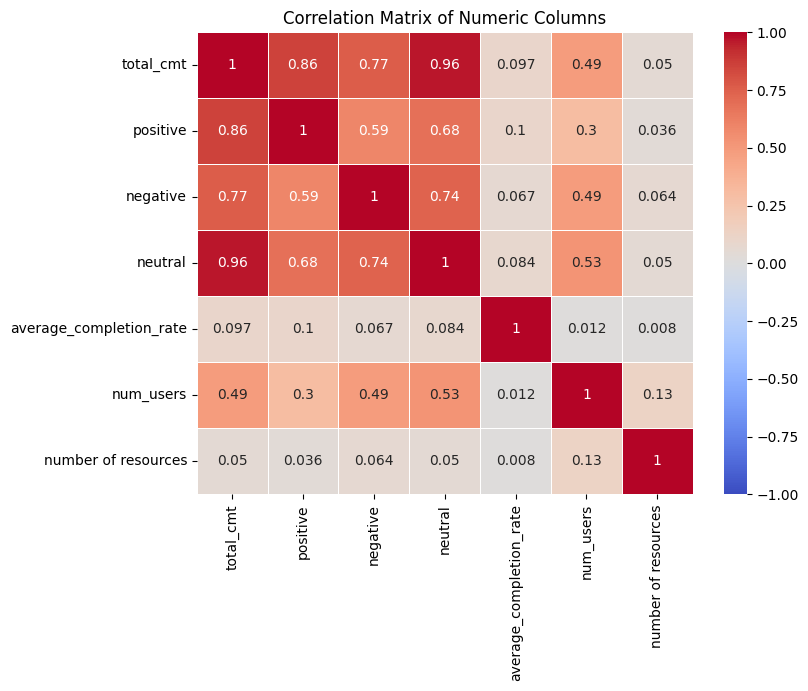

In [ ]:
numeric_columns = ['total_cmt', 'positive',
                   'negative', 'neutral',
                   'average_completion_rate',
                   'num_users', 'number of resources']
correlations = df[numeric_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

**Nhận xét:** Các mối quan hệ giữa các thuộc tính dữ liệu trong ma trận tương quan này có vẻ nhất quán và hợp lý. Các thuộc tính phụ thuộc vào nhau, chẳng hạn như tổng số bình luận và các loại bình luận, có tương quan cao. Trong khi đó, các thuộc tính độc lập như tỷ lệ hoàn thành và số lượng tài nguyên có tương quan thấp với các yếu tố khác.

##4. Tính kịp thời (Timeliness)

Để thực hiện phân tích về độ trễ và tính kịp thời, cần phải có ít nhất một cột hoặc thông tin ghi nhận thời gian cập nhật của từng dòng dữ liệu. Tuy nhiên, bảng dữ liệu hiện tại chỉ chứa thông tin liên quan đến các khóa học và không có thông tin về thời gian cập nhật hoặc thời gian thực hiện. Vì thiếu các cột hoặc thông tin về thời gian, không thể thực hiện các phân tích liên quan đến tính kịp thời hoặc độ trễ một cách đầy đủ.

##5. Tính hợp lệ (Validity)

### 5.1 Phân tích thống kê

#### 5.1.1 Kiểm tra tính chính quy

In [ ]:
from scipy import stats

Kiểm tra tính chính quy cột average_completion_rate

In [ ]:
# Kiểm tra Shapiro-Wilk
# H0: average_completion_rate có phân phối chuẩn
# H1: average_completion_rate không có phân phối chuẩn

shapiro_test = stats.shapiro(df['average_completion_rate'])
print(f"Shapiro-Wilk test: statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk test: statistic=0.5833311187973858, p-value=1.7819370160440704e-63


Nhận xét:


*   p-value rất nhỏ: p-value nhỏ hơn 0.05 (hoặc thậm chí nhỏ hơn nhiều mức ý nghĩa thông thường như 0.001) cho thấy rằng có đủ bằng chứng để bác bỏ giả thuyết không (null hypothesis).
*   Hệ quả: Do đó, có thể kết luận rằng cột average_completion_rate không có phân phối chính quy.



#### 5.1.2 Kiểm tra ngoại lệ

In [ ]:
Q1 = df['number of resources'].quantile(0.25)
Q3 = df['number of resources'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['number of resources'] < lower_bound) | (df['number of resources'] > upper_bound)]
print("Outliers based on IQR:")
print(outliers)

Outliers based on IQR:
             id                                               name  num_users  \
6      C_597314  college chinese literature - appreciation of l...         50   
11     C_674920                              introduction to logic      32466   
15     C_674959     wisdom and enlightenment from the tao te ching       3706   
25     C_676656                                starting a business      21003   
77     C_677093                               portrait photography      12800   
...         ...                                                ...        ...   
2717   C_883345                            data structure (part 1)      78374   
2719   C_770738                            data structure (part 2)      29516   
2725   C_697821                                   operating system      44600   
2742  C_2217528      youth programming ability development program         39   
2818  C_2342532                   fundamentals of circuit analysis        103   

    

#### 5.1.3 Phân tích tương quan

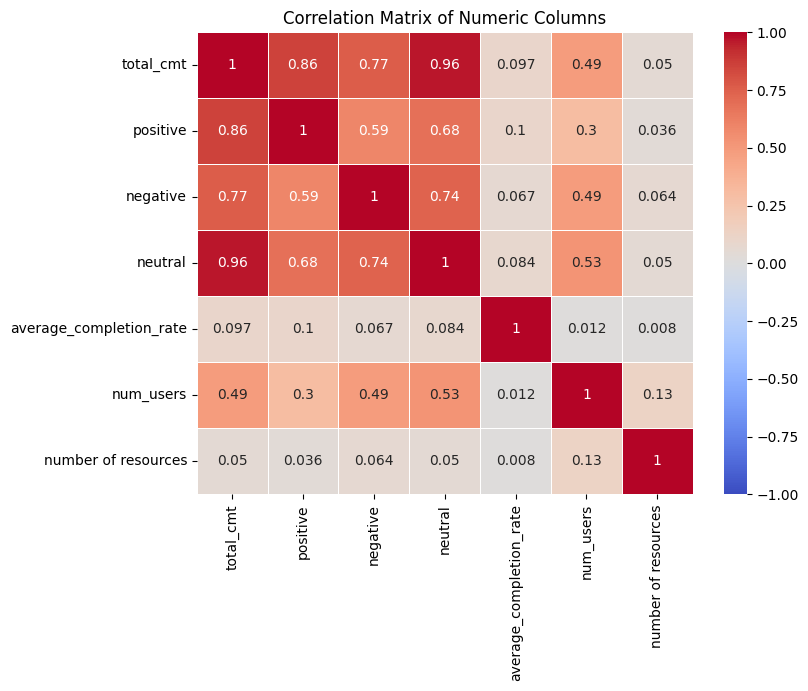

In [ ]:
numeric_columns = ['total_cmt', 'positive', 'negative', 'neutral', 'average_completion_rate', 'num_users', 'number of resources']
correlations = df[numeric_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

**Nhận xét:** Nhìn chung, mối tương quan giữa các thuộc tính dữ liệu là hợp lý và không có giá trị nào quá bất thường. Các biến phụ thuộc lẫn nhau (như các loại bình luận và tổng số bình luận) có mối tương quan cao, trong khi các biến độc lập như average_completion_rate và number of resources có tương quan thấp với các biến khác.

##6. Tính duy nhất (Uniqueness)

### 6.1 Phân tích thống kê

Đối với tác vụ phân tích thống kê, nội dung được thực hiện tương tự như kiểm tra tính nhất quán. Do đó để tránh lặp lại nội dụng nhóm, sẽ không nhắc đến trong mục này.

###6.3 Xác minh dữ liệu

In [ ]:
df['id'].value_counts()

,count
id,
C_769301,196
C_734024,98
C_682770,64
C_707073,64
C_854832,63
...,...
C_865842,1
C_866151,1
C_866167,1


In [ ]:
uniqueness_rate = (df['id'].nunique() / df.shape[0]) * 100
print('Tỷ lệ dữ liệu duy nhất trong data là: ', round(uniqueness_rate, 2), '%')

Tỷ lệ dữ liệu duy nhất trong data là:  26.64 %


In [ ]:
df['name'].value_counts()

,count
name,
introduction to medical specialty medicine,294
engineering mechanics,100
programming basics,93
business logic training camp: the underlying logic that elites are learning,90
postgraduate academic and professional quality lectures,89
...,...
"women's cultivation and cultivation: women's sports, nutrition and health",1
stars who changed the world,1
pediatric oral medicine,1


In [ ]:
df['total_cmt'].value_counts()

,count
total_cmt,
1.0,621
2.0,417
3.0,384
4.0,338
5.0,288
...,...
166.0,1
10054.0,1
854.0,1


In [ ]:
df['positive'].value_counts()

,count
positive,
0.0,1320
1.0,1070
2.0,691
3.0,665
4.0,571
...,...
631.0,1
545.0,1
311.0,1


In [ ]:
df['negative'].value_counts()

,count
negative,
0.0,2431
1.0,1256
2.0,1072
4.0,609
3.0,593
...,...
145.0,1
537.0,1
321.0,1


In [ ]:
df['neutral'].value_counts()

,count
neutral,
1.0,812
2.0,680
0.0,447
3.0,428
10.0,395
...,...
982.0,1
345.0,1
532.0,1


In [ ]:
df['average_completion_rate'].value_counts()

,count
average_completion_rate,
0.000000,114
1.000000,102
0.500000,83
0.737104,64
0.596278,63
...,...
0.618155,1
0.689225,1
0.844349,1


In [ ]:
df['num_users'].value_counts()

,count
num_users,
1,997
8537,196
8,131
2,102
4,81
...,...
1509,1
7926,1
18215,1


In [ ]:
df['number of resources'].value_counts()

,count
number of resources,
83,335
66,286
59,273
70,270
64,230
...,...
498,1
270,1
372,1


In [ ]:
df['rank_binned'].value_counts()

,count
rank_binned,
1.0,4232
9.0,1992
7.0,1621
4.0,1106
5.0,1097
6.0,878
2.0,707
11.0,319
3.0,29


In [ ]:
df['course_classification'].value_counts()

,count
course_classification,
Dissatisfied,597
Very dissatisfied,577
Satisfied,571
Very satisfied,570
Neutral,546


Nhận xét:
*  Cột `id` có các giá trị trùng lặp nên dữ liệu không có tính duy nhất.
* Tỷ lệ dữ liệu duy nhất trong data là: 26.64%.


## 7. Phương pháp xử lý để cải thiện chất lượng dữ liệu:

In [ ]:
improved_df = df.copy()
improved_df

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_584313,"introduction to ""zi zhi tong jian""",3,NaN,NaN,NaN,NaN,NaN,91,1.0,NaN
1,C_584329,calculus - limit theory and functions of one v...,6,NaN,NaN,NaN,NaN,NaN,170,1.0,NaN
2,C_584329,calculus - limit theory and functions of one v...,6,NaN,NaN,NaN,NaN,NaN,170,1.0,NaN
3,C_584381,photojournalism,5,NaN,NaN,NaN,NaN,NaN,127,1.0,NaN
4,C_597208,data mining: theory and algorithms,10,NaN,NaN,NaN,NaN,NaN,125,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14189,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14190,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14191,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14192,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied


### 7.1 Xử lý NaN

Các giá trị NaN trong các cột `total_cmt`, `positive`, `negative`, `neutral` sẽ gán bằng 0

In [ ]:
improved_df[['total_cmt', 'positive', 'negative', 'neutral']] = improved_df[['total_cmt', 'positive', 'negative', 'neutral']].fillna(0)
improved_df

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_584313,"introduction to ""zi zhi tong jian""",3,0.0,0.0,0.0,0.0,NaN,91,1.0,NaN
1,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,NaN,170,1.0,NaN
2,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,NaN,170,1.0,NaN
3,C_584381,photojournalism,5,0.0,0.0,0.0,0.0,NaN,127,1.0,NaN
4,C_597208,data mining: theory and algorithms,10,0.0,0.0,0.0,0.0,NaN,125,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14189,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14190,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14191,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied
14192,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.85056,76,1.0,Very satisfied


Các giá trị NaN trong cột `average_completion_rate` sẽ gán bằng mean

In [ ]:
improved_df['average_completion_rate'] = improved_df['average_completion_rate'].fillna(improved_df['average_completion_rate'].mean())
improved_df

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_584313,"introduction to ""zi zhi tong jian""",3,0.0,0.0,0.0,0.0,0.648872,91,1.0,NaN
1,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,0.648872,170,1.0,NaN
2,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,0.648872,170,1.0,NaN
3,C_584381,photojournalism,5,0.0,0.0,0.0,0.0,0.648872,127,1.0,NaN
4,C_597208,data mining: theory and algorithms,10,0.0,0.0,0.0,0.0,0.648872,125,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14189,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.0,Very satisfied
14190,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.0,Very satisfied
14191,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.0,Very satisfied
14192,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.0,Very satisfied


In [ ]:
improved_df['rank_binned'] = improved_df['rank_binned'].fillna(improved_df['rank_binned'].mean())
improved_df

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
0,C_584313,"introduction to ""zi zhi tong jian""",3,0.0,0.0,0.0,0.0,0.648872,91,1.000000,NaN
1,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,0.648872,170,1.000000,NaN
2,C_584329,calculus - limit theory and functions of one v...,6,0.0,0.0,0.0,0.0,0.648872,170,1.000000,NaN
3,C_584381,photojournalism,5,0.0,0.0,0.0,0.0,0.648872,127,1.000000,NaN
4,C_597208,data mining: theory and algorithms,10,0.0,0.0,0.0,0.0,0.648872,125,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14189,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied
14190,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied
14191,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied
14192,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied


Cột `course_classification` sẽ được gán theo trọng số

In [ ]:
# Bỏ những khóa học có số lượng người học nhỏ hơn 30 (dữ liệu nhiễu)
improved_df = improved_df[improved_df['num_users'] >= 30]

In [ ]:
# Dùng trong xử lý dữ liệu
improved_df['comment_ratio'] = np.where(
    (improved_df['total_cmt'].notnull()) & (improved_df['positive'] != 0),
    improved_df['negative'] / improved_df['positive'],
    0  # Assign 0 if `negative` is 0 or `total_cmt` is null
)

<ipython-input-37-e61ebbbfd294>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df['comment_ratio'] = np.where(


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()

improved_df[['num_users_normalized', 'average_completion_rate_normalized', 'resource_normalized','rank_normalized']] = scaler.fit_transform(
    improved_df[['num_users', 'average_completion_rate', 'number of resources','rank_binned']]
)

<ipython-input-38-62cda28d6217>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df[['num_users_normalized', 'average_completion_rate_normalized', 'resource_normalized','rank_normalized']] = scaler.fit_transform(
<ipython-input-38-62cda28d6217>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df[['num_users_normalized', 'average_completion_rate_normalized', 'resource_normalized','rank_normalized']] = scaler.fit_transform(
<ipython-input-38-62cda28d6217>:6: SettingWithCopyWarning: 
A value 

In [ ]:
w1, w2, w3, w4, w5 = 0.35, 0.2, 0.15, -0.05, 0.35

def adjust_comment_ratio(comment_ratio):
    return comment_ratio * (1 if comment_ratio < 1 else -1)

adjusted_comment_ratio = improved_df['comment_ratio'].apply(adjust_comment_ratio)

improved_df['composite_score'] = (
    w1 * improved_df['num_users_normalized'] +
    w2 * improved_df['average_completion_rate_normalized'] +
    w3 * adjusted_comment_ratio +
    w4 * improved_df['rank_normalized'] +
    w5 * improved_df['resource_normalized']
)

<ipython-input-39-c5d4b0f313df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df['composite_score'] = (


In [ ]:
# Define thresholds for five categories (e.g., very bad, bad, normal, good, very good)
quantiles = improved_df['composite_score'].quantile([0.2, 0.4, 0.6, 0.8])

# Classify courses into five categories based on composite_score
improved_df['course_classification'] = pd.cut(
    improved_df['composite_score'],
    bins=[-float('inf'), quantiles.iloc[0], quantiles.iloc[1], quantiles.iloc[2], quantiles.iloc[3], float('inf')],
    labels=['Very dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very satisfied']
)


<ipython-input-41-e7dac40e5ff3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df['course_classification'] = pd.cut(


In [ ]:
improved_df = improved_df.drop(columns=['composite_score',
                              'comment_ratio',
                              'rank_normalized',
                              'num_users_normalized',
                              'average_completion_rate_normalized',
                              'resource_normalized'])

In [ ]:
improved_df

,id,name,num_users,total_cmt,positive,negative,neutral,average_completion_rate,number of resources,rank_binned,course_classification
42,C_655852,series of courses-completed courses without re...,48,0.0,0.0,0.0,0.0,0.648872,162,9.000000,Dissatisfied
43,C_655850,series of classes - class has not started yet,47,0.0,0.0,0.0,0.0,0.648872,91,1.000000,Neutral
44,C_654554,series of courses - now starting,47,0.0,0.0,0.0,0.0,0.648872,99,4.481596,Dissatisfied
45,C_654506,series of courses - the course has ended and t...,47,0.0,0.0,0.0,0.0,0.648872,3,4.481596,Dissatisfied
46,C_629558,medical immunology and pathogen biology,48,0.0,0.0,0.0,0.0,0.648872,91,4.481596,Dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...
14157,C_2343522,advanced flight dynamics,75,0.0,0.0,0.0,0.0,0.648872,42,7.000000,Dissatisfied
14189,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied
14190,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied
14191,C_1945689,machine learning bootcamp,184,28.0,4.0,2.0,22.0,0.850560,76,1.000000,Very satisfied


### 7.2 Xử lý trùng lặp

In [ ]:
import pandas as pd

# Giả sử improved_df là DataFrame của bạn
# Tìm các giá trị trùng lặp của cột 'id'
duplicate_ids = improved_df[improved_df.duplicated(subset=['id'], keep=False)]

# Kiểm tra và lọc các id có sự khác biệt ở các cột còn lại
different_ids = duplicate_ids.groupby('id').filter(
    lambda x: not x.iloc[:, 1:].eq(x.iloc[0, 1:]).all(axis=1).all()
)['id'].unique()

# Đếm số lượng id có sự khác biệt
count_different_ids = len(different_ids)

# Lưu các id có sự khác biệt vào một DataFrame mới
different_ids_df = pd.DataFrame(different_ids, columns=['id'])

print(f"Số lượng các id có sự khác biệt: {count_different_ids}")
print("Danh sách các id có sự khác biệt:")
print(different_ids_df)


Số lượng các id có sự khác biệt: 70
Danh sách các id có sự khác biệt:
           id
0    C_676898
1    C_680789
2    C_680804
3    C_680807
4    C_681001
..        ...
65   C_887103
66  C_1912014
67  C_1924175
68  C_2033958
69  C_2189666

[70 rows x 1 columns]


In [ ]:
improved_df = improved_df.drop_duplicates(subset=['id'])
improved_df.shape

(2822, 11)

#### Nhận xét: kích thước của bộ dữ liệu từ 12260 dòng chỉ còn 2822 dòng, cho thấy dữ liệu ban đầu bị trùng lặp khá nhiều

### 7.3 Xử lý độ chính xác

In [ ]:
improved_df = improved_df[
    (improved_df['total_cmt'] >= 0) &
    (improved_df['positive'] >= 0) &
    (improved_df['negative'] >= 0) &
    (improved_df['neutral'] >= 0) &
    (improved_df['num_users'] >= 0) &
    (improved_df['number of resources'] >= 0) &
    (improved_df['average_completion_rate'] >= 0) &
    (improved_df['average_completion_rate'] <= 1) &
    (improved_df['course_classification'].isin(['Very dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very satisfied']) &
    (improved_df['total_cmt'] == (improved_df['positive'] + improved_df['neutral'] + improved_df['negative'])))
]

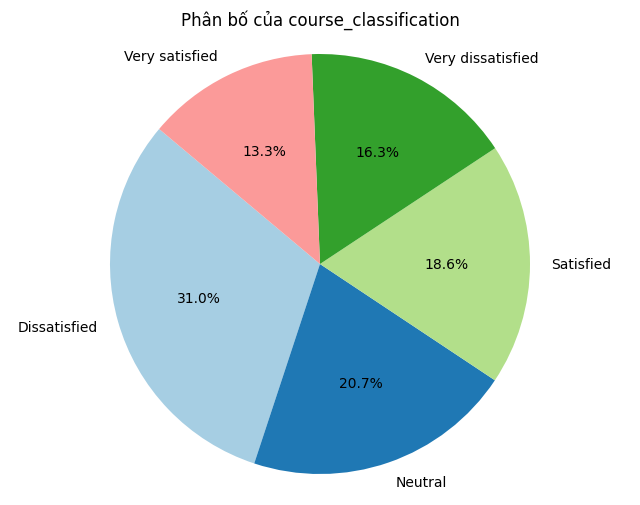

In [ ]:
import matplotlib.pyplot as plt

# Giả sử df là DataFrame đã được định nghĩa
# Đếm số lượng giá trị của mỗi loại trong cột 'course_classification'
course_classification_counts = improved_df['course_classification'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 6))
plt.pie(course_classification_counts, labels=course_classification_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(course_classification_counts))))
plt.title('Phân bố của course_classification')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()

In [ ]:
improved_df.to_csv('/gdrive/MyDrive/Nhóm 1/2 Bài tập trên lớp/Thực hành Final/Data processed/final_dataset_improved.csv', index=False)

##8. Phân tích độ nhạy

###8.1 Xử lý dữ liệu bị NaN trong raw_data để tiến hành phân tích độ nhạy

In [ ]:
raw_df = df.dropna(subset=['course_classification'])
raw_df.shape

(2861, 11)

In [ ]:
# Loại bỏ các hàng trùng lặp dựa trên cột 'id'
raw_df = raw_df.drop_duplicates(subset=['id'])

# Kiểm tra kết quả
raw_df.shape

(312, 11)

###8.2 Chạy model để phân tích độ nhạy

Phân tích độ nhạy sẽ được tiến hành trên cả DataFrame raw ban đầu có lỗi và DataFrame đã được cải thiện. Dữ liệu sẽ được chia theo tỉ lệ 8:2 để tạo thành tập huấn luyện và tập kiểm tra. Sử dụng thuật toán Random Forest và các độ đo precision, recall, f1-score, accuracy để đánh giá.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

### Raw_data

In [ ]:
X = raw_df.drop(columns=['id', 'name', 'course_classification'])
y = raw_df['course_classification']

classification_mapping = {
    'Very dissatisfied': 0,
    'Dissatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Very satisfied': 4
}
y = y.map(classification_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.50      0.75      0.60        12
           2       0.72      0.76      0.74        17
           3       0.29      0.25      0.27         8
           4       0.50      0.50      0.50        12

    accuracy                           0.57        63
   macro avg       0.55      0.54      0.53        63
weighted avg       0.59      0.57      0.57        63



### Improved_data

In [ ]:
X = improved_df.drop(columns=['id', 'name', 'course_classification'])
y = improved_df['course_classification']

classification_mapping = {
    'Very dissatisfied': 0,
    'Dissatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Very satisfied': 4
}
y = y.map(classification_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        94
           1       0.95      0.94      0.94       165
           2       0.85      0.85      0.85       111
           3       0.70      0.77      0.73       104
           4       0.76      0.66      0.71        91

    accuracy                           0.83       565
   macro avg       0.82      0.82      0.82       565
weighted avg       0.83      0.83      0.83       565



Nhận xét:
* Những dữ liệu lỗi có ảnh hưởng đến độ chính xác của model.
* Bộ dữ liệu lỗi có độ chính xác khá thấp 0.57, bộ dữ liệu sau khi được cải thiện có độ chính xác khá tốt 0.83.
* Các metrics khác như `precision`, `recall`, `f1-score` bộ dữ liệu sau cải tiến đều cao hơn raw data.